# Research Notebook
## Arthana Sri Renganathan
## Date: January 12 - January 22, 2026

# 1: Experience
## Describe at least one research activity you worked on this week. 

- Plotted baryon rotation curves to test if data loaded properly.
- I wrote a code to create a baryon potential function that takes in radius and upsilon as arguments.
- I tried to apply this function for all radii and not just a specific region (using extrapolation techniques discussed in tutorials).

## Motivation:

The baryon potential function determined from the SPARC rotation curve dataset will allow us to see the baryonic contribution to the potential function of Dark Matter (DM) halos. This is one of 4 inputs we must put into the Jeans model (a model for SIDM based on equilibrium solutions from the collisional Boltzmann equations) so that in the end we can make cross-section inferences.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

To start with, there are 2 equations worth mentioning from Ref. [1]:

\begin{equation}
V_b^2(r) = \Upsilon_*V_{disk}^2(r) + \Upsilon_{bulge}V_{bulge}^2(r)+V_{gas}^2(r)
\tag{8}
\end{equation}

\begin{equation}
\Phi_b(r) = \Phi_b(\infty) - \int_{r}^{\infty} \frac{1}{r^\prime}(\Upsilon_*V_{disk}^2(r^\prime) + \Upsilon_{bulge}V_{bulge}^2(r^\prime)+V_{gas}^2(r^\prime))\, dr^\prime
\tag{9}
\end{equation}

__Equation 8__ represents the baryonic rotation curve with the disk, bulge, and gas components, along with $\Upsilon$, the mass/light ratio. We take the data from SPARC as a dataframe (df) and use it to interpolate the baryonic velocity at many radii, not just the ones provided in the data. Next, we can use __Equation 9__ to solve for the baryonic potential function. Keep in mind that we need this as a function, not an array of values, so that we can extrapolate the data later on.

Below, I have provided the code I have been working on in the last week, which is mainly based on the 2 equations from above. I have also added the baryonic rotation curve code (which was not written by me, but used to see if data loaded properly). The integrals were done numerically, so no derivations are provided.

__Baryonic Rotation Curve Code__ (not written by me, it was provided by Adam Smith-Orlik)

    #plot the rotation curve and its components
    
    SMTLdisk = 0.5  # example mass-to-light ratio for disk
    SMTLbulge = 0.7  # example mass-to-light ratio for bulge
    
    #total baryon component
    Vbaryon = np.sqrt(SMTLdisk * df['Vdisk']**2 + SMTLbulge * df['Vbul']**2 + df['Vgas']**2)
    #total dark matter component inferred 
    Vhalo = np.sqrt(df['Vobs']**2 - Vbaryon**2)
    
    #plotting 
    plt.figure(figsize=(8,6))
    plt.errorbar(df['Rad'], df['Vobs'], yerr=df['errV'], fmt='o', label='Observed', color='black', markersize=5)
    plt.plot(df['Rad'], df['Vdisk'], label='Disk', color='C0')
    plt.plot(df['Rad'], df['Vgas'], label='Gas', color='C1')
    plt.plot(df['Rad'], df['Vbul'], label='Bulge', color='C2') 
    plt.plot(df['Rad'], Vbaryon, label='Baryonic Total', color='C3', linestyle='--')
    plt.plot(df['Rad'], Vhalo, label='Halo', color='grey', linestyle='--')
    
    
    plt.xlabel(f"Radius ({units.at[0, 'Rad']})")
    plt.ylabel(f"Velocity ({units.at[0, 'Vobs']})")
    plt.title(f"Rotation Curve for {Dataset} (Distance: {dist} Mpc)")
    plt.legend()
    plt.grid()
    plt.show()

    
__Baryonic Potential Code__ (code I made)

    import numpy as np
    import scipy.integrate as integrate
    from scipy.integrate import cumulative_simpson
    from scipy.integrate import cumulative_trapezoid
    from scipy.interpolate import InterpolatedUnivariateSpline
    
    # Values
    SMTLdisk = 0.5  # example mass-to-light ratio for disk
    SMTLbulge = 0.7  # example mass-to-light ratio for bulge
    r_min = np.min(df['Rad'])
    r_max = np.max(df['Rad'])
    rad = df['Rad']
    
    # 1. Interpolate AND extrapolate V values: (The spline will do both at the same time.) We can use InterpolatedUnivariateSpline.- tutorial 7
    Vdisk_spline = InterpolatedUnivariateSpline(rad,df['Vdisk'],ext=0)
    Vbulge_spline = InterpolatedUnivariateSpline(rad,df['Vbul'],ext=0)
    Vgas_spline = InterpolatedUnivariateSpline(rad,df['Vgas'],ext=0)
    
    # 2. Integrate Function  of 'baryon_pot'
    def baryon_pot_integrand(r,UpsilonDisk,UpsilonBulge):
        Vbaryon2 = SMTLdisk * Vdisk_spline(r)**2 + SMTLbulge * Vbulge_spline(r)**2 + Vgas_spline(r)**2
        integrand = -(1/r)*Vbaryon2
        return integrand
    
    # 3. Use existing data and interpolate to make a baryonic function.
    # arb = arbitrary
    
    rad_arb = np.linspace(r_min,r_max,20)
    phiB_arb = baryon_pot_integrand(rad_arb,SMTLdisk,SMTLbulge)
    phiB_interp = InterpolatedUnivariateSpline(rad_arb,phiB_arb,ext=0)
    
    # 4. Compute the integral and get the baryonic potential function
    #bar_pot = phiB_interp.antiderivative()
    #bar_pot = cumulative_trapezoid(phiB_arb,rad_arb,initial=0.0)
    bar_pot = cumulative_simpson(phiB_arb,initial=0.0)
    print("Check: ",bar_pot)
    
    #If using trapzoidal method or simpson, don't need to call rad_arb because the values in bar_plot
    # are array of values asscociated with each rad_arb. So just use bar_plot. Must call for antiderivative tho.
    #Make sure to normalize so as it approch infinity potential is zero.
    phi0 = bar_pot[-1]
    print(phi0)
    phiB_plot = phi0 - bar_pot
    print("Values: ",phiB_plot)
    
    # 5. Baryon Potential Plots
    plt.figure(figsize=(8,6))
    plt.plot(rad_arb, phiB_plot, label='Baryon Plot', color='C0')
    plt.xlabel(f"Radius ({units.at[0, 'Rad']})")
    plt.ylabel(f"Baryonic Potential")
    plt.title(f"Baryonic Potential for {Dataset} (Distance: {dist} Mpc)")
    plt.legend()
    plt.grid()
    plt.show()

This week, I was able to complete the task of creating the potential function and have discussed my code and output with my peers through chat.

# 3: So what? (What does it mean?)
## Describe your results

As mentioned before, we can determine the baryonic potential for the SPARC data and use it for the Jeans model. We will need to determine which galaxies to use to run the model as well. Below, I have provided 2 outputs from both codes above.

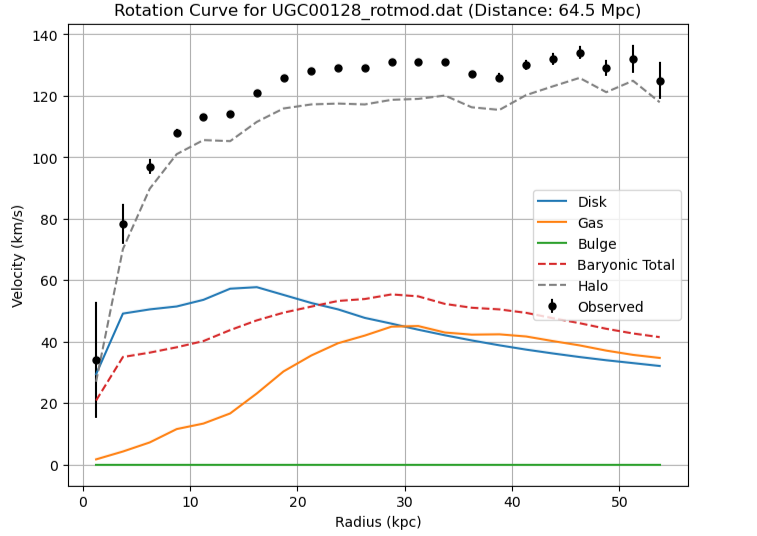
*Figure 1: Rotation Curve for UGC00128_rotmod from different components (disk, gas, bulge, baryonic total, halo, observed results)*

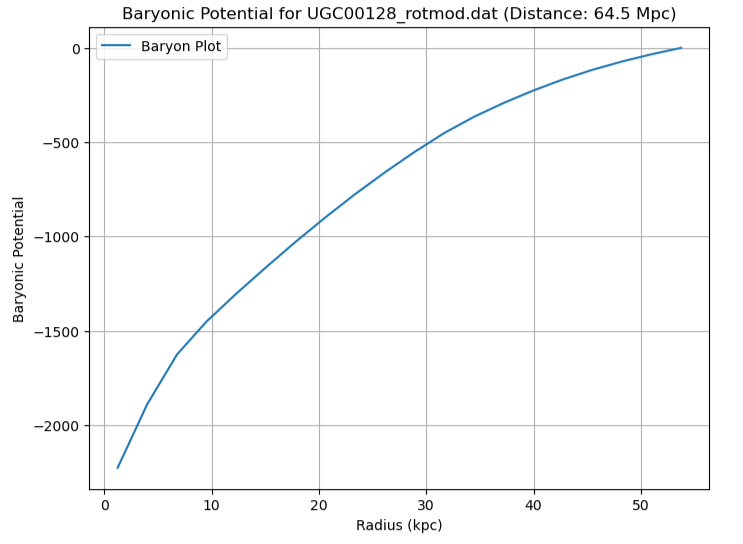
*Figure 2: Baryonic potential curve with reference point at max radius (kpc)*

In __Figure 1__, the curve gives us an idea of the different contributions to the mass/velocity. We also get a sense of scale due to the large differences in velocities from the observed to the baryonic total (no halo). In __Figure 2__, the baryon potential is interpolated from the data given and is just what we expect; increasing but approaching zero as the radius goes to a maximum. These graphs show the significance of the prescence baryonic matter in models, to get a more accurate match with observed results.

Since the results turned out to be what we expected, we can now use this for the Jeans model.

# 4. Now what? (What's next?)
## Plan for the next week

My intended goal was to create the baryonic potential function. Following this, my next steps are to apply this function to a wider range of radii (extrapolate), which I have attempted to work on by implementing extrapolation parameters within the code (ext=0 in InterpolatedUnivariateSpline as learned in Tutorial 7). But, as always, it isn't that simple. The extrapolation given above won't work for this case and will produce inaccurate results. We need to be able to use a formula given in the Ren paper [1] that holds mass constant as radii larger than $r_{max}$ increases. Then we need to extrapolate for radii less than $r_{min}$, where a seperate function must be used.

# 5. Bibliography

[1] Ren, T., Kwa, A., Manoj Kaplinghat, & Yu, H.-B. (2019). *Reconciling the Diversity and Uniformity of Galactic Rotation Curves with Self-Interacting Dark Matter*. Physical Review. X, 9(3). https://doi.org/10.1103/physrevx.9.031020